In [1]:
%matplotlib notebook

import numpy as np
import math
import os

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset
from l5kit.rasterization import build_rasterizer

from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import preprocessing

from ripser import ripser
from persim import plot_diagrams

import sys
sys.path.append('../..')

import network
import backpack as bp

Net(
  (fc1): Linear(in_features=396, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [2]:
os.environ['L5KIT_DATA_FOLDER'] = '../../dataset'
dm = LocalDataManager(None)

cfg = load_config_data('./config.yaml')
print(cfg)

{'format_version': 4, 'model_params': {'model_architecture': 'resnet50', 'history_num_frames': 0, 'history_step_size': 1, 'history_delta_time': 0.1, 'future_num_frames': 50, 'future_step_size': 1, 'future_delta_time': 0.1}, 'raster_params': {'raster_size': [224, 224], 'pixel_size': [0.5, 0.5], 'ego_center': [0.25, 0.5], 'map_type': 'py_semantic', 'satellite_map_key': 'aerial_map/aerial_map.png', 'semantic_map_key': 'semantic_map/semantic_map.pb', 'dataset_meta_key': 'meta.json', 'filter_agents_threshold': 0.5, 'disable_traffic_light_faces': False}, 'train_data_loader': {'key': 'scenes/train.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'val_data_loader': {'key': 'scenes/sample.zarr', 'batch_size': 12, 'shuffle': False, 'num_workers': 16}, 'train_params': {'checkpoint_every_n_steps': 10000, 'max_num_steps': 5, 'eval_every_n_steps': 10000}}


In [3]:
train_cfg = cfg['train_data_loader']
rasterizer = build_rasterizer(cfg, dm)
train_zarr = ChunkedDataset(dm.require(train_cfg['key'])).open()

In [4]:
scenes = train_zarr.scenes
frames = train_zarr.frames
agents = train_zarr.agents

In [18]:
def map_scene_array_to_dict(array):
    return dict(zip(['frame_index_interval', 'host', 'start_time', 'end_time'], array))
def map_frame_array_to_dict(array):
    return dict(zip(['timestamp', 'agent_index_interval', 'ego_blank', 'ego_translation','ego_rotation'], array))
def map_agent_array_to_dict(array):
    return dict(zip(['centroid', 'extent', 'yaw', 'velocity', 'track_id'], array))
def map_ret_to_dict(array):
    return dict(zip(['coordinates','velocity','yaw','tags'],array))

def getData(scene,frames,agents):
    key_frames = frames[scene['frame_index_interval'][0]:scene['frame_index_interval'][1]]
    key_agents = agents[key_frames[0]['agent_index_interval'][0]:key_frames[-1]['agent_index_interval'][1]]
    
    key_frames = [map_frame_array_to_dict(f) for f in key_frames]
    key_agents = [map_agent_array_to_dict(a) for a in key_agents]
    
    start_agent_index = key_frames[0]['agent_index_interval'][0]
    num_frames = scene['frame_index_interval'][1]-scene['frame_index_interval'][0]
    
    ret_agents = np.ones((3000,4,num_frames,2))
    ret_agents[1] = ret_agents[1]*-1 #vels
    ret_agents[2] = ret_agents[2]*2 #yaws
    ret_agents[3] = ret_agents[3]*-1 #tags
    
    for frame_num in range(num_frames):
        frame = key_frames[frame_num]
        ret_agents[0][0][frame_num] = frame['ego_translation'][:2]
        ret_agents[2][0][frame_num][0] = math.acos(frame['ego_rotation'][0][0])
        for j in range(frame['agent_index_interval'][0]-start_agent_index,frame['agent_index_interval'][1]-start_agent_index):
            agent = key_agents[j]
            ret_agents[0][agent['track_id']][frame_num] = agent['centroid']
            ret_agents[1][agent['track_id']][frame_num] = agent['velocity']
            ret_agents[2][agent['track_id']][frame_num][0] = agent['yaw']
            ret_agents[3][agent['track_id']][frame_num][0] = j
            
    ret_agents = map_ret_to_dict(ret_agents)
    return ret_agents

def findPathMatch(ret_agents,start,end):
    ret = []
    coords = ret_agents['coordinates']
    for agent_num in range(len(coords)):
        agent = coords[agent_num]
        if len(getWithout(agent,1)) > 20:
            match = [False,False]
            for pos in agent:
                if sum((pos - start)**2) < 10:
                    match[0] = True
                if sum((pos - end)**2) < 10:
                    match[1] = True
                    break
            if sum(match) == 2:
                ret.append(coords[agent_num])
    return ret

def getWithout(arr,n):
    return arr[arr!=n]

def getAverageSpeed(agent_num,vels):
    return np.mean(getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def getDensitiesAll(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            #print(distance_from_edge(agents[agent_index],agents[pos[frame_num]]))
            #print(distance_from_center(agents[agent_index],agents[pos[frame_num]]))
            temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
        densities.append(temp)
    return np.array(densities,dtype = object)

def getDensitiesMoving(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num]['agent_index_interval'][1]-frames[frame_num]['agent_index_interval'][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num]['agent_index_interval'][0],frames[frame_num]['agent_index_interval'][1])):
            if math.hypot(agents[agent_index]['velocity'][0],agents[agent_index]['velocity'][1]) > 1:
                temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
            else:
                temp[agent_count] = 1000
        densities.append(temp)
    return np.array(densities,dtype = object)

def returnDensitiesDistances(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = np.sort(densities[frame_num])[k+1]
    return dist_densities

def returnDensitiesRadius(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = (densities[frame_num]<k).sum()
    return dist_densities

def getAgentDensities(agent_num,tags,agents,frames,k,t):
    if t[0] == 0:
        densities = getDensitiesAll(agent_num,tags,agents,frames)
    else:
        densities = getDensitiesMoving(agent_num,tags,agents,frames)
    if t[1] == 0:
        ret = returnDensitiesDistances(densities,k)
    else:
        ret = returnDensitiesRadius(densities,k)
    return ret

def plotAgentPos(coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(coords[:,0],1),getWithout(coords[:,1],1),zs = np.arange(len(coords))[coords[:,0]!=1],s=3)
    plt.title("Example Trajectory of Agent")
    ax.set_xlabel('$x-coordinate$')
    ax.set_ylabel('$y-coordinate$')
    ax.set_zlabel('Time',rotation = 270)
    plt.show()
    
def plotAgentVel(vels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(vels[:,0],-1),getWithout(vels[:,1],-1),zs = np.arange(len(vels))[vels[:,0]!=-1],s=3)
    plt.title("Example Velocity Graph of Agent")
    ax.set_xlabel('$x-component$')
    ax.set_ylabel('$y-component$')
    ax.set_zlabel('Time',rotation = 270)
    plt.show()
    
def plotAgentYaw(yaws):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(yaws))[yaws[:,0]!=2],getWithout(yaws[:,0],2))
    
    plt.title("Example Yaw Graph of Agent")

    ax.set_xlabel('Time')
    ax.set_ylabel('Yaw')
    plt.show()
    plt.show()
    
def plotAgentSpeed(vels):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(vels))[vels[:,0]!=-1],getWithout((vels[:,0]**2+vels[:,1]**2)**.5,math.sqrt(2)))
    plt.title("Example Speed Graph of Agent")

    ax.set_xlabel('Time')
    ax.set_ylabel('Speed')
    plt.show()

def plotAgentDensity(agent_density):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(agent_density))[agent_density!=-1],getWithout(agent_density,-1))

In [102]:
d = network.DL(scenes[39],frames,agents)
start = d.dataframe[0]['coordinates'][50]
end = d.dataframe[0]['coordinates'][125]

In [43]:
dict = {}
for i in range(100):
    d = network.DL(scenes[i],frames,agents)
    for j in range(1000):
        if len(getWithout(d.dataframe[j]['prob'][:,0],0)) > 0:
            id = np.average(getWithout(d.dataframe[j]['prob'][:,0],0)).round()
            if id not in dict:
                dict[id] = 0
            dict[id] += 1


In [49]:
print(dict)

{3.0: 20757, 1.0: 64133, 14.0: 2556, 4.0: 13, 2.0: 551, 10.0: 30, 9.0: 21, 12.0: 189, 6.0: 18, 13.0: 46, 11.0: 49, 8.0: 18, 5.0: 3, 7.0: 11}


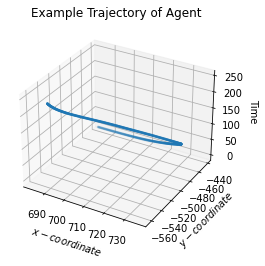

In [7]:
plotAgentPos(d.dataframe[0]['coordinates'])

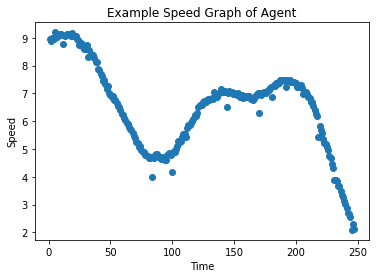

In [8]:
plotAgentSpeed(d.dataframe[0]['velocity'])

<IPython.core.display.Javascript object>


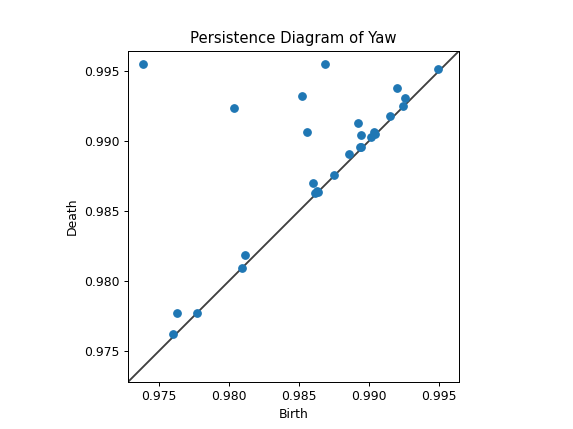

In [103]:
plt.figure()
ax = plt.subplot(121)
ax.scatter(np.arange(len(d.dataframe[0]['yaw']))[d.dataframe[0]['yaw'][:,0]!=2],getWithout(d.dataframe[0]['yaw'][:,0],2))
    
# plt.title("Example Yaw Graph of Agent")

# ax.set_xlabel('Time')
# ax.set_ylabel('Yaw')

ax = plt.subplot(111)
birth,death = bp.calculateSignalHomology(getWithout(d.dataframe[0]['yaw'][:,0],2))

ax.scatter(birth,death)
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.title("Persistence Diagram of Yaw")
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

ax.set_xlabel('Birth')
ax.set_ylabel('Death')

plt.show()



In [25]:
#alg = []
for i,scene in tqdm(enumerate(scenes)):
    d = network.DL(scenes[i+4947],frames,agents)
    out = d.findPathMatch(start,end)
    #print("num agents", len(out))
    if len(out) > 0:
        for agent in out:
            alg.append(agent)

    if i%100 == 0:
        spd = np.ones((len(alg),250))*math.sqrt(2)
        for k in range(len(alg)):
            spd[k][:len(alg[k]['velocity'])] = (alg[k]['velocity'][:,0]**2 + alg[k]['velocity'][:,1]**2)**0.5

        file = open("spd", "wb")
        np.save(file,spd)
        file.close

    if i+4947 == 5000:
        break

    
        

53it [00:43,  1.22it/s]


In [2]:
read_file = open("point_cloud", "rb")  #READ IN PC
#read the file to numpy array
pc = np.load(read_file)
#close the file

In [3]:
read_file = open("spd", "rb")
#read the file to numpy array
spd = np.load(read_file)
#close the file

In [4]:
read_file = open("yaw_final", "rb")
#read the file to numpy array
yaw = np.load(read_file)
#close the file

In [25]:
alg = []
for i,scene in tqdm(enumerate(scenes)):

    d = network.DL(scenes[i],frames,agents)
    out = d.findPathMatch(start,end)
    #print("num agents", len(out))
    if len(out) > 0:
        for agent in out:
            alg.append(agent)
    
    if i%500 == 0:
        yaws = np.ones((len(alg),250))*2
        for i in range(len(alg)):
            yaws[i][:len(alg[i]['yaw'])] = alg[i]['yaw'][:,0]
    
    if i ==4000:
        break

open_inds = np.zeros((len(alg),2))
point_cloud = np.zeros((len(alg),3))
for agent_num in range(len(alg)):
    agent = alg[agent_num]
    t = agent['coordinates']
    si = [sum((k - start)**2) for k in t]
    se = [sum((k - end)**2) for k in t]
    start_ind = np.where(si == np.amin(si))[0][0]
    end_ind = np.where(se == np.amin(se))[0][0]
    #traj_indices.append([start_ind,end_ind])
    point_cloud[agent_num][0] = end_ind - start_ind
    open_inds[agent_num][0] = start_ind
    open_inds[agent_num][1] = end_ind
    v = agent['velocity']
    min_speed = np.amin((v[:,0][start_ind:end_ind]**2+v[:,1][start_ind:end_ind]**2)**.5)
    point_cloud[agent_num][1] = min_speed
    y = agent['yaw'][:,0][start_ind:end_ind]
    total = (y[-1] - y[0])/(end_ind-start_ind)
    sharpness = np.array([abs((y[-1] - y[i])/ ((end_ind-start_ind) - i)) for i in range(end_ind-start_ind)])
    point_cloud[agent_num][2] = np.amax(sharpness)
    
file = open("point_cloud_4000_5000", "wb")
np.save(file,point_cloud)
file.close

53it [00:45,  1.16it/s]


<function BufferedWriter.close>

<IPython.core.display.Javascript object>


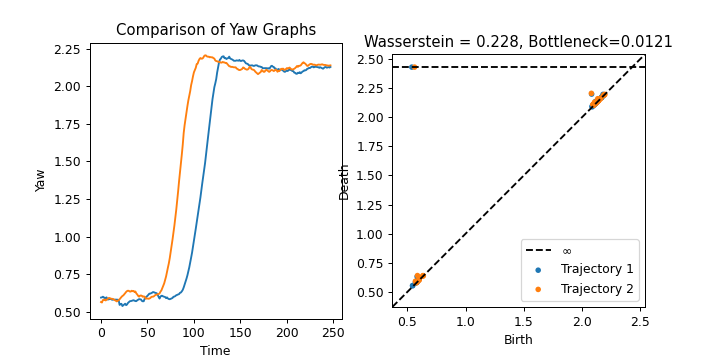

Elapsed time Wasserstein: 0
Elapsed time Bottleneck: 0.0629


<IPython.core.display.Javascript object>


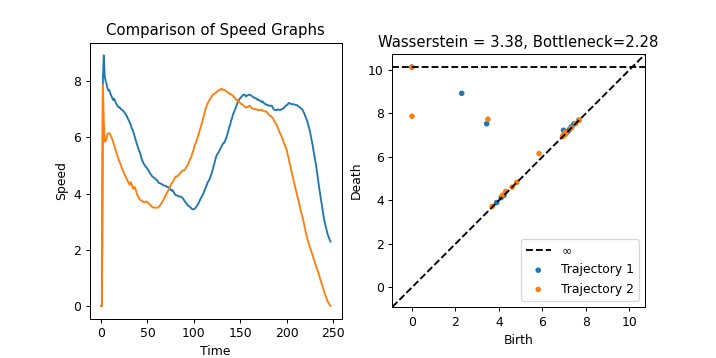

Elapsed time Wasserstein: 0
Elapsed time Bottleneck: 0


In [19]:
compareTrajectories("yaw",9,11)
compareTrajectories("spd",9,11)

In [15]:
def compareTrajectories(dtype,p1,p2):
    if dtype == "yaw":
        X = getWithout(abs(yaw[p1]),2)
        Y = getWithout(abs(yaw[p2]),2)
    else:
        X = getWithout(abs(spd[p1]),math.sqrt(2))
        Y = getWithout(abs(spd[p2]),math.sqrt(2))

    Dx = getLowerStarTimeSeriesD(X)
    Dy = getLowerStarTimeSeriesD(Y)
    Ix = ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
    Iy = ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]


    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.plot(X)
    plt.plot(Y)
    plt.xlabel("Time")
    if dtype == "yaw":
        plt.ylabel("Yaw")
        plt.title("Comparison of Yaw Graphs")
    else:
        plt.ylabel("Speed")
        plt.title("Comparison of Speed Graphs")
   
    plt.subplot(122)
    plot_diagrams([Ix, Iy], labels = ['Trajectory 1', 'Trajectory 2'])

    #Remove point at infinity before bottleneck/wasserstein
    Ix = Ix[np.isfinite(Ix[:, 1]), :]
    Iy = Iy[np.isfinite(Iy[:, 1]), :]

    tic = time.time()
    dw = wasserstein(Ix, Iy)
    print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
    tic = time.time()
    db = bottleneck(Ix, Iy)
    print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
    plt.title("Wasserstein = %.3g, Bottleneck=%.3g"%(dw, db))
    plt.show()

<IPython.core.display.Javascript object>


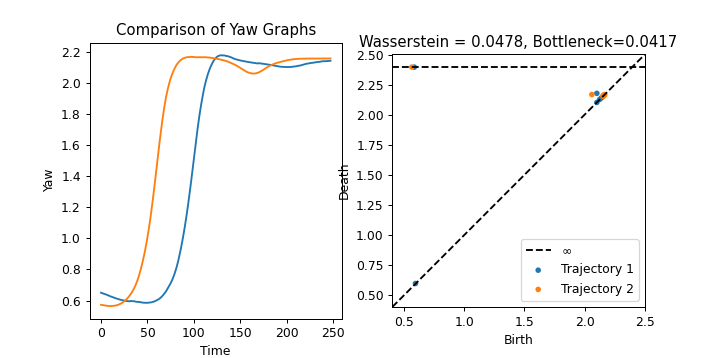

Elapsed time Wasserstein: 0.001
Elapsed time Bottleneck: 0.002


In [22]:
def getLowerStarTimeSeriesD(x):
    N = x.size
    # Add edges between adjacent points in the time series, with the "distance" 
    # along the edge equal to the max value of the points it connects
    I = np.arange(N-1)
    J = np.arange(1, N)
    V = np.maximum(x[0:-1], x[1::])
    # Add vertex birth times along the diagonal of the distance matrix
    I = np.concatenate((I, np.arange(N)))
    J = np.concatenate((J, np.arange(N)))
    V = np.concatenate((V, x))
    #Create the sparse distance matrix
    D = sparse.coo_matrix((V, (I, J)), shape=(N, N)).tocsr()
    return D

X = getWithout(abs(yaw[0]),2)
Y = getWithout(abs(yaw[10]),2)

Dx = getLowerStarTimeSeriesD(X)
Dy = getLowerStarTimeSeriesD(Y)
Ix = ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
Iy = ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]


plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.plot(X)
plt.plot(Y)
plt.xlabel("Time")
plt.ylabel("Yaw")
plt.title("Comparison of Yaw Graphs")
plt.subplot(122)
plot_diagrams([Ix, Iy], labels = ['Trajectory 1', 'Trajectory 2'])

#Remove point at infinity before bottleneck/wasserstein
Ix = Ix[np.isfinite(Ix[:, 1]), :]
Iy = Iy[np.isfinite(Iy[:, 1]), :]

tic = time.time()
dw = wasserstein(Ix, Iy)
print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
tic = time.time()
db = bottleneck(Ix, Iy)
print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
plt.title("Wasserstein = %.3g, Bottleneck=%.3g"%(dw, db))
plt.show()

In [23]:
yawpd_wasserstein = np.zeros((len(yaw),len(yaw)))
yawpd_bottleneck = np.zeros((len(yaw),len(yaw)))

for i in tqdm(range(len(yaw))):
    for j in range(len(yaw)):
        X = getWithout(abs(yaw[i]),2)
        Y = getWithout(abs(yaw[j]),2)

        Dx = getLowerStarTimeSeriesD(X)
        Dy = getLowerStarTimeSeriesD(Y)
        Ix = ripser(Dx, distance_matrix=True, maxdim=0)['dgms'][0]
        Iy = ripser(Dy, distance_matrix=True, maxdim=0)['dgms'][0]

        #Remove point at infinity before bottleneck/wasserstein
        Ix = Ix[np.isfinite(Ix[:, 1]), :]
        Iy = Iy[np.isfinite(Iy[:, 1]), :]

        #tic = time.time()
        yawpd_wasserstein[i][j] = wasserstein(Ix, Iy)
        #print("Elapsed time Wasserstein: %.3g"%(time.time()-tic))
        #tic = time.time()
        yawpd_bottleneck[i][j] = bottleneck(Ix, Iy)
        #print("Elapsed time Bottleneck: %.3g"%(time.time()-tic))
        #plt.title("Wasserstein = %.3g, Bottleneck=%.3g"%(dw, db))
        #plt.show()
    

100%|███████████████████████████████████████████████████████████| 155/155 [05:25<00:00,  2.10s/it]


<IPython.core.display.Javascript object>


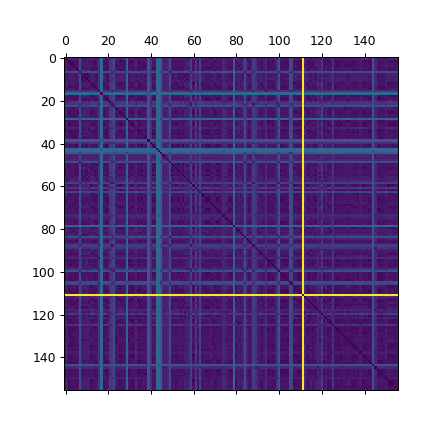

In [50]:
plt.matshow(yawpd_bottleneck)

<IPython.core.display.Javascript object>


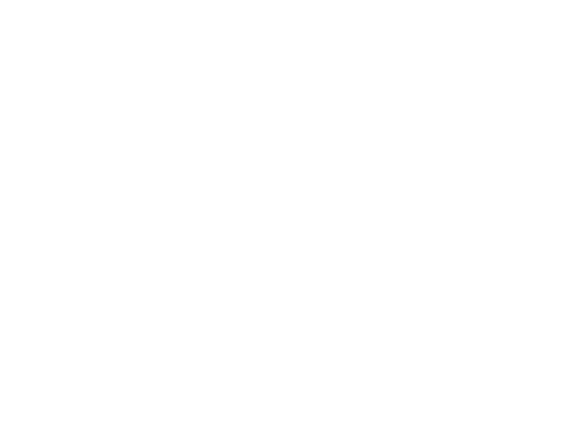

NameError: name 'alg' is not defined

In [20]:
fig = plt.figure()
ax = plt.subplot()
for a in alg:
    ax.scatter(getWithout(a['coordinates'][:,0],1),getWithout(a['coordinates'][:,1],1),s=3)
plt.title("Example of Agents on same Trajectory")
ax.set_ylabel("y-coordinate")
ax.set_xlabel("x-coordinate")
plt.show()

<IPython.core.display.Javascript object>


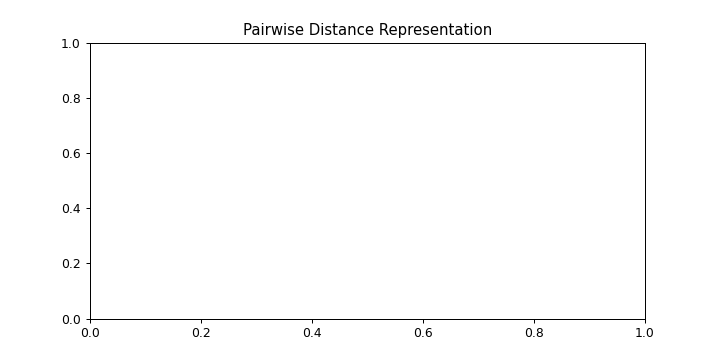

In [7]:
X = np.zeros((len(pc),3))
X[:,0] = preprocessing.normalize([pc[:,0]])
X[:,1] = preprocessing.normalize([pc[:,1]])
X[:,2] = preprocessing.normalize([pc[:,2]])
xr = [np.min(X.flatten()), np.max(X.flatten())]

res = ripser(X, maxdim=2)
dgms = res['dgms']

plt.figure(figsize=(8, 4))
#ax = plt.subplot(121, projection='3d')
#ax.scatter(X[:, 0], X[:, 1], X[:, 2])
#ax.set_xlim(xr)
#ax.set_ylim(xr)
#ax.set_zlim(xr)
plt.subplot(121)
plt.title("Persistance Diagram for Point Cloud")
plot_diagrams(dgms)
plt.show()

Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.00975)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.072)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.015)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.003)
Doing spatial.Delaunay triangulation...
Finished spatial.Delaunay triangulation (Elapsed Time 0.00309)
Building alpha filtration...
Finished building alpha filtration (Elapsed Time 0.126)
Constructing boundary matrix...
Finished constructing boundary matrix (Elapsed Time 0.02)
Computing persistence pairs...
Finished computing persistence pairs (Elapsed Time 0.003)
Elapsed Time Matching: 0.943


<IPython.core.display.Javascript object>


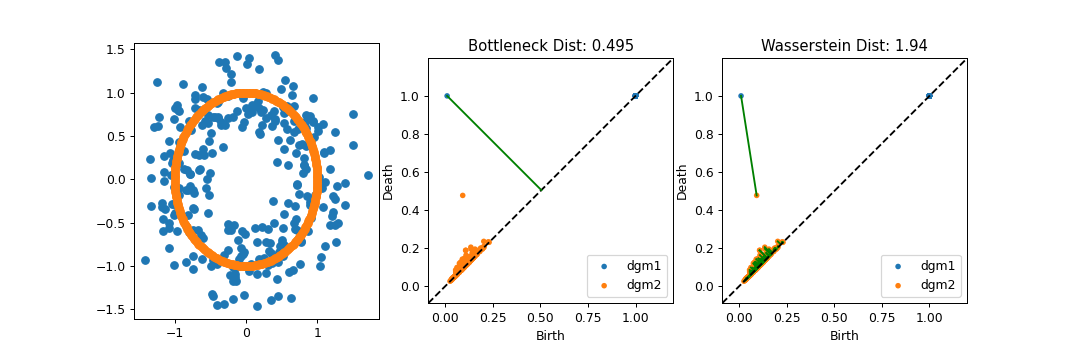

In [20]:
#Do all of the imports and setup inline plotting
import time
import numpy as np
from scipy import sparse
from ripser import ripser
import cechmate as cm
from persim import plot_diagrams
from persim import wasserstein, wasserstein_matching
from persim import bottleneck, bottleneck_matching

%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

# First, sample points from a circle

# First point cloud has no noise
N1 = 300
X1 = np.zeros((N1, 2))
t1 = np.linspace(0, 2*np.pi, N1+1)[0:N1]
X1[:, 0] = np.cos(t1)
X1[:, 1] = np.sin(t1)

# Second point cloud has a lot of noisy points
N2 = 300
t2 = np.linspace(0, 2*np.pi, N2+1)[0:N2]
X2 = np.zeros((N2, 2))
X2[:, 0] = np.cos(t2)
X2[:, 1] = np.sin(t2)
X2 = X2 + 0.25*np.random.randn(N2, 2)

alpha = cm.Alpha()
filtration = alpha.build(X1)
I1 = alpha.diagrams(filtration)[1]
filtration = alpha.build(X2)
I2 = alpha.diagrams(filtration)[1]

# Perform the matchings
tic = time.time()
bdist, (matchidxb, bD) = bottleneck(I1, I2, matching=True)
wdist, (matchidxw, wD) = wasserstein(I1, I2, matching=True)
print("Elapsed Time Matching: %.3g"%(time.time()-tic))

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.scatter(X2[:, 0], X2[:, 1])
plt.scatter(X1[:, 0], X1[:, 1])
plt.subplot(132)
bottleneck_matching(I1, I2, matchidxb, bD)
plt.title("Bottleneck Dist: %.3g"%bdist)
plt.subplot(133)
wasserstein_matching(I1, I2, matchidxw)
plt.title("Wasserstein Dist: %.3g"%wdist)
plt.show()

<IPython.core.display.Javascript object>


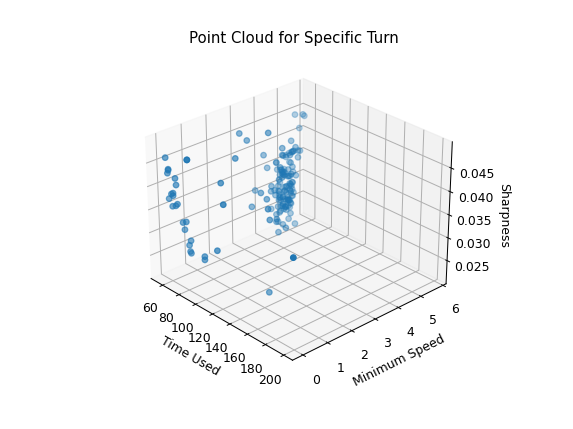

In [53]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#Axes3D.scatter(ax,pc[:,0]/10,pc[:,1],pc[:,2]*100)
Axes3D.scatter(ax,pc[:,0],pc[:,1],pc[:,2])
plt.title('Point Cloud for Specific Turn')
ax.set_xlabel('Time Used')
ax.set_ylabel('Minimum Speed')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Sharpness',rotation = 270)
plt.show()

In [8]:
#x is loaded pairwise dist in R3
pairwise_dist = np.zeros((len(X),len(X)))
for i in range(len(X)):
    pairwise_dist[i] = [np.linalg.norm(X[i] - X[j]) for j in range(len(X))]
    
#r = 1 / pairwise_dist.max() 
#pairwise_dist = pairwise_dist*r
s = np.argsort(pairwise_dist[0])

npd = np.zeros((len(X),len(X)))
for i,row in enumerate(pairwise_dist[s]):
    npd[i] = row[s]

<IPython.core.display.Javascript object>


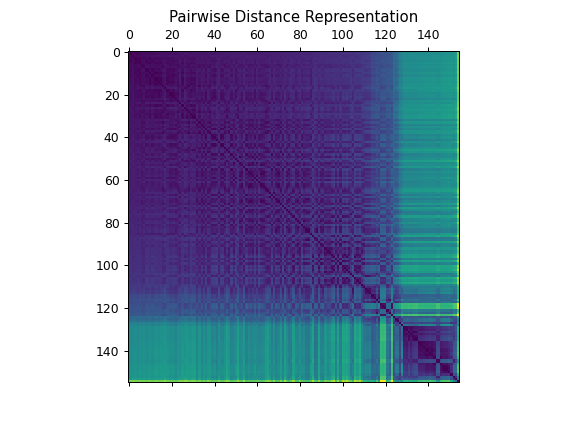

In [15]:
plt.figure()
ax = plt.subplot(111)
plt.title("Pairwise Distance Representation")

ax.matshow(npd)
plt.show()

<IPython.core.display.Javascript object>


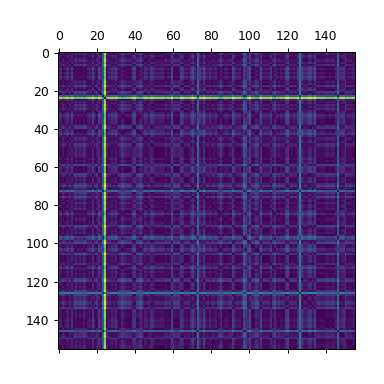

In [62]:
plt.matshow(pairwise_dist)

In [124]:
d = network.DL(scenes[0],frames,agents)
a = d.dataframe[0]

<IPython.core.display.Javascript object>


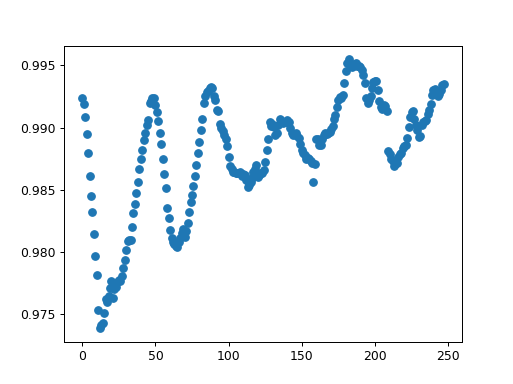

In [135]:
plt.figure()
ax = plt.subplot('111')
ax.scatter(np.arange(len(getWithout(a['yaw'][:,0],2))),getWithout(a['yaw'][:,0],2))

In [136]:
def calcYawSlope(yaw):
    for i in range(2,len(yaw)-2):
        a1 = yaw[i] - yaw[i]
        #FINISH TOMOROW

SyntaxError: unexpected EOF while parsing (<ipython-input-136-4828879ea71c>, line 1)

In [ ]:
alg[0]['velocity']

In [ ]:
plt.scatter(np.arange(248),(alg[0]['velocity'][:,0]**2+alg[0]['velocity'][:,1]**2)**.5)

In [ ]:
for agent_num in range(len(alg)):
    y = alg[agent_num]['yaw']
    inds = traj_indices[agent_num]
    for i in range(inds[0],inds[1]):
        print(y[i])
    break

In [ ]:
plt.scatter(alg[0]['velocity'][75:125,0],alg[0]['velocity'][75:125,1])

In [ ]:
ret = getData(scenes[39],frames,agents)

In [ ]:
len(alg[1]['yaw'])

In [ ]:
plt.scatter(np.arange(248),alg[0]['yaw'][:,0])

In [ ]:
alg[0]['yaw']

In [ ]:
birth[0],death[0]

In [ ]:
birth,death = calculateSignalHomology(alg[1]['yaw'][:,0]*10)
bp.plotSignalHomology(birth,death)

In [ ]:
alg[1]['yaw']

In [ ]:
def calculateSignalHomology(y):
    '''
    :param y: numpy array of values 
    :return: birth and death arrays of y
    '''
    x = np.arange(len(y))
    sy = np.sort(y)
    res = [] 
    [res.append(z) for z in sy if z not in res] 
    cc = {}
    birth = []
    death = []
    for s in res:
        ind = np.where(y == s)[0]
        for i in ind:
            if i-1 not in cc and i+1 not in cc:
                cc[i] = s
            else:
                if i-1 not in cc:
                    cc[i] = cc[i+1]
                    #birth.append(s)
                    #death.append(s)
                elif i+1 not in cc:
                    cc[i] = cc[i-1]
                    #birth.append(s)
                    #death.append(s)
                else:
                    cc[i] = min(cc[i-1],cc[i+1])
                    if cc[i-1] <= cc[i+1]:
                        birth.append(cc[i+1])
                        death.append(s)
                        j = i+1
                        while j in cc:
                            cc[j] = cc[i-1]
                            j += 1
                    if cc[i-1] > cc[i+1]:
                        birth.append(cc[i-1])
                        death.append(s)
                        j = i-1
                        while j in cc:
                            cc[j] = cc[i+1]
                            j -= 1
    birth.append(sy[0])
    death.append(sy[-1])
    return birth, death

In [ ]:
birth

In [ ]:
ret = getData(scenes[39],frames,agents)
k = 0
plotAgentPos(k,ret['coordinates'])
plotAgentVel(k,ret['velocity'])
plotAgentYaw(k,ret['yaw'])

In [ ]:
r = getProfileY(0,d.dataframe['yaw']*100)

In [ ]:
plotAgentDensity(dens)

In [ ]:
dens

In [ ]:
dens = getAgentDensities(1,tags,agents,frames,3,[0,0])

In [ ]:
vels[1]

In [ ]:
getAgentDensities(1,tags,agents,frames,1,[0,0])

In [ ]:
getDensitiesMoving(1,coords,frames)

In [ ]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,100:150,0], coords[0,100:150, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,100:150,0],0),getWithout(coords[j,100:150,1],0))

plt.show()


In [ ]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,:99,0], coords[0,:99, 1],color = 'red')
for j in range(1,2000):
    #if (coords[j,:99,0]!=0).sum()>50:
    plt.plot(getWithout(coords[j,:99,0],0),getWithout(coords[j,:99,1],0))

plt.show()


In [ ]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,99,0], coords[0,99, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,99,0],0),getWithout(coords[:,99,1],0),marker = '.')

plt.show()


In [ ]:
for agent in agents[1000:10000]:
    print(agent['label_probabilities'].nonzero()[0][0]!=1 and agent['label_probabilities'].nonzero()[0][0]!=3)

In [ ]:
ax = plt.gca()

ax.set_autoscale_on(True)
ax.plot(coords[0,150,0], coords[0,150, 1],color = 'orange',marker = '.')

ax.scatter(getWithout(coords[:,150,0],0),getWithout(coords[:,150,1],0),marker = '.')

plt.show()

In [ ]:
def getVelocity(scene,frames):
    coords = -1 * np.ones((2000,scene[0][1]-scene[0][0],2))
    for i in tqdm(range(scene[0][0],scene[0][1])):
        frame = frames[i]
        for j in range(frame[1][0],frame[1][1]):
            agent = agents[j]
            coords[agent[-2]][i-scene[0][0]] = agent[3]
    return coords

In [ ]:
vels = getVelocity(scenes[1],frames)
graphVelocity(vels)

In [ ]:
agents[0]

In [ ]:
def getProfileY(agent_num,vels):
    vel = vels[agent_num]
    
    X = np.zeros((len(getWithout(vel[:,0],2)),2))
    X[:,0] = (np.arange(len(vel[:,0]))[vel[:,0]!=2])
    X[:,1] = (getWithout(vel[:,0],2))
    
    dgms = ripser(X)['dgms']

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter((np.arange(len(vel[:,0]))[vel[:,0]!=2]),(getWithout(vel[:,0],2)))

    plt.title("Point Cloud")
    plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    return X

In [ ]:
def getProfile(agent_num,vels):
    vel = vels[agent_num]
    
    X = np.zeros((len(getWithout(vel[:,0],-1)),2))
    X[:,0] = (np.arange(len(vel[:,0]))[vel[:,0]!=-1])
    X[:,1] = (getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)**0.5
    
    dgms = ripser(X)['dgms']

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.scatter((np.arange(len(vel[:,0]))[vel[:,0]!=-1])[1:],(getWithout(vel[:,0],-1)**2 + getWithout(vel[:,1],-1)**2)[1:]**0.5)

    plt.title("Point Cloud")
    plt.subplot(122)
    plot_diagrams(dgms)
    plt.show()
    return X

In [ ]:
def graphVelocity(coords):
    fig,ax = plt.subplots()
    for j in range(1,2000):
        if (coords[j,:,0]!=-1).sum() > 50:
            ax.scatter(coords[j,:,0][coords[j,:,0]!=-1],coords[j,:,1][coords[j,:,1]!=-1],color = ((j%1000)/1000.0,(j%10)/10.0,(j%100)/100.0),label = j)

    #ax.legend()
    plt.show()

In [ ]:
def distance_from_center(agent1, agent2):
    '''
    Calculates the distance between the centroids of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distk ance between the two agents' centroids
    '''
    return np.linalg.norm(agent1['centroid'] - agent2['centroid'])

def distance_from_edge(agent1, agent2):
    '''
    Calculates the distance between the closest edges of two agents
    @param agent1 - AgentDataset dictionary that represents first agent
    @param agent2 - AgentDataset dictionary that represents second agent
    @return - numpy float distance between two agents' closest edges
    '''
        
    # generate orthogonal axes for each agent
    a1_length_axis = agent1['extent'][1] / 2 * np.array([np.cos(agent1['yaw']), np.sin(agent1['yaw'])])
    a1_width_axis  = agent1['extent'][0] / 2 * np.array([np.sin(agent1['yaw']), np.cos(agent1['yaw'])])
    a2_length_axis = agent2['extent'][1] / 2 * np.array([np.cos(agent2['yaw']), np.sin(agent2['yaw'])])
    a2_width_axis  = agent2['extent'][0] / 2 * np.array([np.sin(agent2['yaw']), np.cos(agent2['yaw'])])
        
    # find all of the corners
    a1_corners = np.asarray([agent1['centroid'] + a1_length_axis * a + a1_width_axis * a for a in [-1, 1]])
    a2_corners = np.asarray([agent2['centroid'] + a2_length_axis * a + a2_width_axis * a for a in [-1, 1]])
    
    # convert corners into cartesian intervals
    a1_max = np.maximum(*a1_corners)
    a1_min = np.minimum(*a1_corners)
    a2_max = np.maximum(*a2_corners)
    a2_min = np.minimum(*a2_corners)
    
    # compute minkowski distance for rectangles
    y = np.maximum(0, np.maximum(a1_min - a2_max, a2_min - a1_max))
    
    return np.sum(np.abs(y) ** 2, axis=-1) ** (1/2)

In [ ]:
distance_from_center(dataset[1], dataset[5])

In [ ]:
distance_from_edge(dataset[1], dataset[5])

In [ ]:
def getAgentData(scene,frames):
    coords = np.zeros((2000,scene[0][1]-scene[0][0],2)) #2000 is arbitrary number
    vels = -1 * np.ones((2000,scene[0][1]-scene[0][0],2)) #2000 is arbitrary number
    tags = -1 * np.ones((2000,scene[0][1]-scene[0][0])) #2000 is arbitrary number
    yaws = 2 * np.ones((2000,scene[0][1]-scene[0][0])) #2000 is arbitrary number
    for frame_counter,frame_num in enumerate(tqdm(range(scene[0][0],scene[0][1]))):
        frame = frames[frame_num]
        coords[0][frame_counter] = frame[3][:2]
        yaws[0][frame_counter] = math.acos(frame[4][0][0])
        for j in range(frame[1][0],frame[1][1]):
            agent = agents[j]
            coords[agent[4]][frame_counter] = agent[0]
            vels[agent[4]][frame_counter] = agent[3]
            tags[agent[4]][frame_counter] = j
            yaws[agent[4]][frame_counter] = agent[2]
    return coords,vels,tags.astype(int),yaws

def getWithout(arr,n):
    return arr[arr!=n]

def getAverageSpeed(agent_num,vels):
    return np.mean(getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def getDensitiesAll(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num][1][1]-frames[frame_num][1][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num][1][0],frames[frame_num][1][1])):
            #print(distance_from_edge(agents[agent_index],agents[pos[frame_num]]))
            #print(distance_from_center(agents[agent_index],agents[pos[frame_num]]))
            temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
        densities.append(temp)
    return np.array(densities,dtype = object)

def getDensitiesMoving(agent_num,tags,agents,frames):
    pos = tags[agent_num]
    densities = []
    for frame_num in range(len(pos)):
        if pos[frame_num] == -1:
            densities.append([0])
            continue
        temp = np.zeros((frames[frame_num][1][1]-frames[frame_num][1][0]))
        for agent_count,agent_index in enumerate(range(frames[frame_num][1][0],frames[frame_num]['agent_index_interval'][1])):
            if math.hypot(agents[agent_index][3][0],agents[agent_index][3][1]) > 1:
                temp[agent_count] = distance_from_edge(agents[agent_index],agents[pos[frame_num]])
            else:
                temp[agent_count] = 1000
        densities.append(temp)
    return np.array(densities,dtype = object)

def returnDensitiesDistances(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = np.sort(densities[frame_num])[k+1]
    return dist_densities

def returnDensitiesRadius(densities,k):
    dist_densities = -1 * np.ones((len(densities)))
    for frame_num in range(len(densities)):
        if len(densities[frame_num])==1:
            continue
        dist_densities[frame_num] = (densities[frame_num]<k).sum()
    return dist_densities

def getAgentDensities(agent_num,tags,agents,frames,k,t):
    if t[0] == 0:
        densities = getDensitiesAll(agent_num,tags,agents,frames)
    else:
        densities = getDensitiesMoving(agent_num,tags,agents,frames)
    if t[1] == 0:
        ret = returnDensitiesDistances(densities,k)
    else:
        ret = returnDensitiesRadius(densities,k)
    return ret

def plotAgentPos(agent_num,coords):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(coords[agent_num][:,0],0),getWithout(coords[agent_num][:,1],0),zs = np.arange(len(coords[agent_num]))[coords[agent_num][:,0]!=0],s=3)
    plt.show()
    
def plotAgentVel(agent_num,vels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    Axes3D.scatter(ax,getWithout(vels[agent_num][:,0],-1),getWithout(vels[agent_num][:,1],-1),zs = np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],s=3)
    plt.show()
    
def plotAgentYaw(agent_num,yaws):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(yaws[agent_num]))[yaws[agent_num]!=2],getWithout(yaws[agent_num],2))
    plt.show()
    
def plotAgentSpeed(agent_num,vels):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(vels[agent_num]))[vels[agent_num][:,0]!=-1],getWithout((vels[agent_num][:,0]**2+vels[agent_num][:,1]**2)**.5,math.sqrt(2)))

def plotAgentDensity(agent_density):
    fig = plt.figure()
    ax = plt.subplot()
    ax.scatter(np.arange(len(agent_density))[agent_density!=-1],getWithout(agent_density,-1))